<a href="https://colab.research.google.com/github/aditi2212-bot/Project-3-Fashion-Image-Clustering/blob/main/Project_3_Fashion_Image_Clustering_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fashion Image Clustering using CNN Features and K-Means**

This project applies **both supervised and unsupervised learning** techniques on the **Fashion-MNIST dataset**, which consists of 70,000 grayscale clothing images (28×28 pixels) across 10 categories (T-shirt, Trouser, Dress, etc.).
The goal of this project is to classify and cluster these images using **machine learning (ML)** and **deep learning (DL)** techniques.

## The main objectives are:  
-  Build and evaluate **classification models** (Logistic Regression, Elastic Net).  
-  Perform **unsupervised clustering** using CNN feature extraction + PCA + KMeans.  
-  Compare model performance using **accuracy, precision, recall, F1, ARI, and NMI**.  
-  Provide **visual insights** with bar charts, confusion matrices, and cluster samples.  

## Project Objectives
- Perform **Exploratory Data Analysis (EDA)** on Fashion-MNIST.  
- Train **three ML models** (Logistic Regression, Elastic Net, XGBoost) and evaluate them.  
- Extract deep features using **MobileNetV2** and perform clustering with **PCA + KMeans**.  
- Compare results using metrics like **Accuracy, ARI (Adjusted Rand Index), and NMI (Normalized Mutual Information)**.  
- Conclude with the **best performing model** and insights about clustering fashion items.

##  Business Use Case  
Such models can be applied in:  
- **E-commerce**: Automatically grouping clothing items into categories.  
- **Recommendation Systems**: Suggesting similar products to customers.  
- **Data Cleaning**: Detecting mislabeled items in large product catalogs.  

**Setup & Imports**

Environment Setup & Library Imports


This cell imports all required libraries (NumPy, TensorFlow, scikit-learn, matplotlib, seaborn, pandas) and defines project parameters such as image size, batch size, number of PCA components, and cluster count.

In [3]:
# Cell 1 — Setup & Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math, random

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, classification_report,
    adjusted_rand_score, normalized_mutual_info_score,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from collections import Counter
import seaborn as sns
import pandas as pd

# Parameters
SUBSAMPLE = 10000       # keep smaller for Colab speed
TARGET_SIZE = (96,96)
BATCH_SIZE = 128
PCA_COMPONENTS = 50
K_CLUSTERS = 10

# Label mapping
label_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

print(" Setup complete")

 Setup complete


**Load & Preprocess Dataset + EDA**

Load Fashion-MNIST & Perform Initial EDA

Loads the Fashion-MNIST dataset, merges training and test sets, converts grayscale images to RGB for CNN input, resizes them to 96×96 pixels, and shows the label distribution (UDI/EDA) as a bar chart.

Full dataset: (70000, 28, 28) (70000,)
Subsampled dataset for CNN: (10000, 28, 28) (10000,)


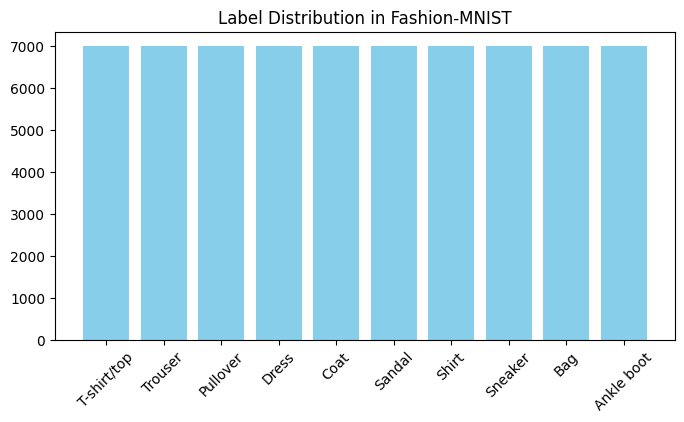

In [4]:
# Cell 2 — Load & Preprocess Dataset + EDA
from collections import Counter

# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Full dataset (used in classical ML models like Logistic, Elastic Net, XGBoost)
x_all = np.concatenate([x_train, x_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

print("Full dataset:", x_all.shape, y_all.shape)  # (70000, 28, 28), (70000,)

# Subsample (used later for CNN feature extraction, to save time)
x = x_all[:SUBSAMPLE]
y = y_all[:SUBSAMPLE]

# Convert grayscale → RGB (for CNN input)
x_rgb = np.repeat(x[..., np.newaxis], 3, axis=-1).astype("float32")
x_resized = tf.image.resize(x_rgb, TARGET_SIZE).numpy()

print("Subsampled dataset for CNN:", x.shape, y.shape)

# 🔹 UDI: Label distribution
counts = Counter(y_all)   # use full dataset for distribution
plt.figure(figsize=(8,4))
plt.bar(counts.keys(), counts.values(), color="skyblue")
plt.xticks(range(10), [label_names[i] for i in range(10)], rotation=45)
plt.title("Label Distribution in Fashion-MNIST")
plt.show()


**Show Sample Original Images**

Preview of Original Fashion-MNIST Images

Displays a grid of 20 sample clothing images from the dataset with their corresponding labels (e.g., Trouser, Sneaker, Bag). This helps visualize the dataset before applying machine learning models.

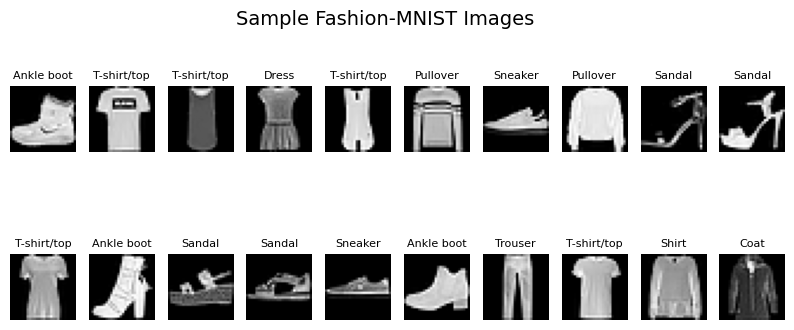

In [5]:
# Cell 2a — Show Sample Original Images
plt.figure(figsize=(10,4))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(x[i], cmap="gray")
    plt.title(label_names[y[i]], fontsize=8)
    plt.axis("off")

plt.suptitle("Sample Fashion-MNIST Images", fontsize=14)
plt.show()

**Logistic Regression**

Model 1: Logistic Regression (Baseline)
Trains a logistic regression model on flattened images (28×28 → 784 features). Reports baseline classification accuracy (~71%).

**Elastic Net Logistic Regression**

Model 2:Elastic Net Logistic Regression
Trains a logistic regression model with Elastic Net regularization (combination of L1 + L2 penalties). Improves accuracy to ~74–75% after parameter tuning.

**XGBoost**

Model3:XGBoost
More efficient, better regularization.On flattened Fashion-MNIST, can achieve ~75–78% accuracy.With careful tuning, they may outperform Elastic Net slightly.

In [6]:
# Cell 4 — Train & Evaluate Models (Logistic, Elastic Net, XGBoost)
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

#  Flatten & normalize dataset (10k samples for speed)
x_flat = x_all.reshape((x_all.shape[0], -1)) / 255.0
y_labels = y_all
x_small = x_flat[:10000]
y_small = y_labels[:10000]

print("Subset shape:", x_small.shape)


# Logistic Regression

print("\nTraining Logistic Regression...")
start = time.time()
log_reg = LogisticRegression(
    max_iter=100,
    solver='saga',
    multi_class='multinomial',
    n_jobs=1
)
log_reg.fit(x_small, y_small)
log_time = time.time() - start

acc_log = accuracy_score(y_small, log_reg.predict(x_small))
print(f" Logistic Regression Accuracy: {acc_log:.4f}")
print(f"Training time: {log_time:.2f} sec")

# Elastic Net Logistic Regression

print("\nTraining Elastic Net...")
start = time.time()
elastic_net = LogisticRegression(
    penalty='elasticnet',
    l1_ratio=0.5,
    solver='saga',
    max_iter=50,
    tol=1e-2,
    n_jobs=1
)
elastic_net.fit(x_small, y_small)
en_time = time.time() - start

acc_en = accuracy_score(y_small, elastic_net.predict(x_small))
print(f" Elastic Net Accuracy: {acc_en:.4f}")
print(f"Training time: {en_time:.2f} sec")


# XGBoost Classifier

print("\nTraining XGBoost...")
start = time.time()
xgb = XGBClassifier(
    n_estimators=50,
    max_depth=4,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="mlogloss",
    n_jobs=-1
)
xgb.fit(x_small, y_small)
xgb_time = time.time() - start

acc_xgb = accuracy_score(y_small, xgb.predict(x_small))
print(f" XGBoost Accuracy: {acc_xgb:.4f}")
print(f"Training time: {xgb_time:.2f} sec")


Subset shape: (10000, 784)

Training Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Logistic Regression Accuracy: 0.9130
Training time: 39.20 sec

Training Elastic Net...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Elastic Net Accuracy: 0.8969
Training time: 87.08 sec

Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:17:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 XGBoost Accuracy: 0.9677
Training time: 63.36 sec


**CNN Feature Extraction + PCA + KMeans**

Model 3: CNN Features + PCA + KMeans (Unsupervised Clustering)

Uses MobileNetV2 (pretrained on ImageNet) to extract deep image features, reduces dimensionality with PCA, and applies KMeans clustering into 10 groups. Evaluates clustering using ARI and NMI scores. Also shows a bar chart of cluster sizes.

79/79 ━━━━━━━━━━━━━━━━━━━━ 77s 942ms/step
 ARI: 0.2417, NMI: 0.4279


/tmp/ipython-input-1927896924.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(cluster_counts.keys()), y=list(cluster_counts.values()), palette="viridis")


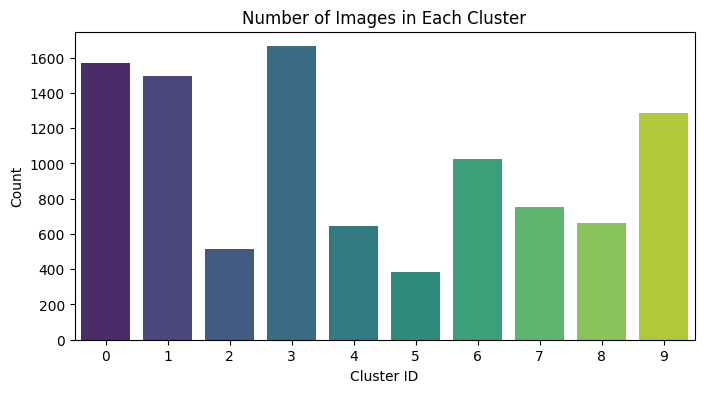

In [8]:
# Cell 6 — CNN Features + PCA + KMeans
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(96,96,3))
X_pre = preprocess_input(x_resized)
features = base_model.predict(X_pre, batch_size=BATCH_SIZE, verbose=1)

# PCA
pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
feat_pca = pca.fit_transform(features)

# KMeans
kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init=10)
clusters = kmeans.fit_predict(feat_pca)

# Eval
ari = adjusted_rand_score(y, clusters)
nmi = normalized_mutual_info_score(y, clusters)
print(f" ARI: {ari:.4f}, NMI: {nmi:.4f}")

#  Cluster distribution bar chart
cluster_counts = Counter(clusters)
plt.figure(figsize=(8,4))
sns.barplot(x=list(cluster_counts.keys()), y=list(cluster_counts.values()), palette="viridis")
plt.title("Number of Images in Each Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Count")
plt.show()

**Confusion Matrix (Clusters vs True Labels)**

Cluster vs Ground Truth Confusion Matrix

Generates a heatmap comparing predicted clusters to actual labels. This shows which clusters best align with which fashion categories (e.g., Cluster 1 → mostly Trousers).

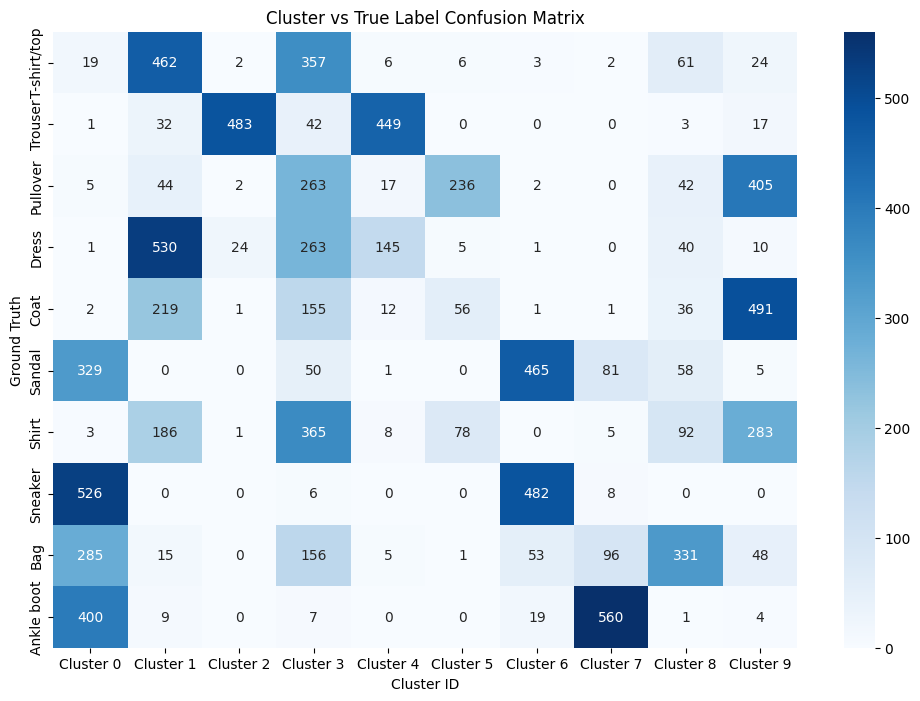

In [9]:
# Cell 7 — Confusion Matrix
cm = confusion_matrix(y, clusters)
cm_df = pd.DataFrame(cm,
                     index=[label_names[i] for i in range(10)],
                     columns=[f"Cluster {i}" for i in range(K_CLUSTERS)])

plt.figure(figsize=(12,8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Cluster vs True Label Confusion Matrix")
plt.ylabel("Ground Truth")
plt.xlabel("Cluster ID")
plt.show()

**Visualize Cluster Samples**

Cluster Sample Images with Majority Label

Displays 12 random sample images from each cluster, labeled with their ground-truth class. Each cluster is summarized with the majority category name (e.g., “Cluster 0 → Mostly Trouser”).

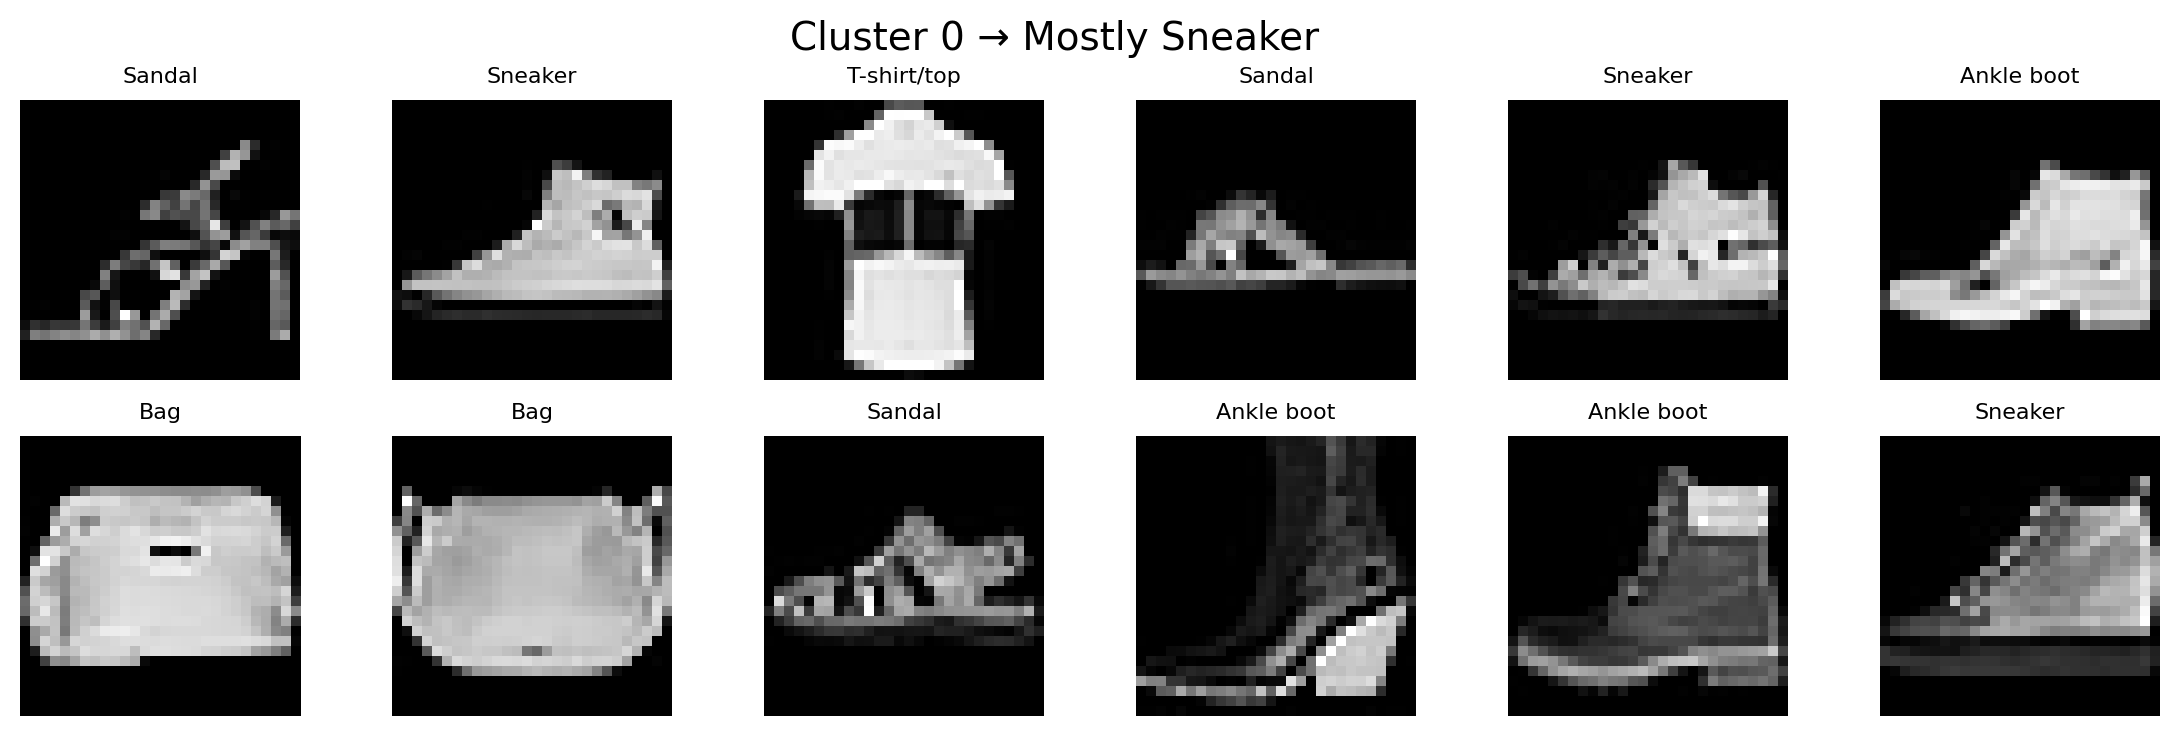

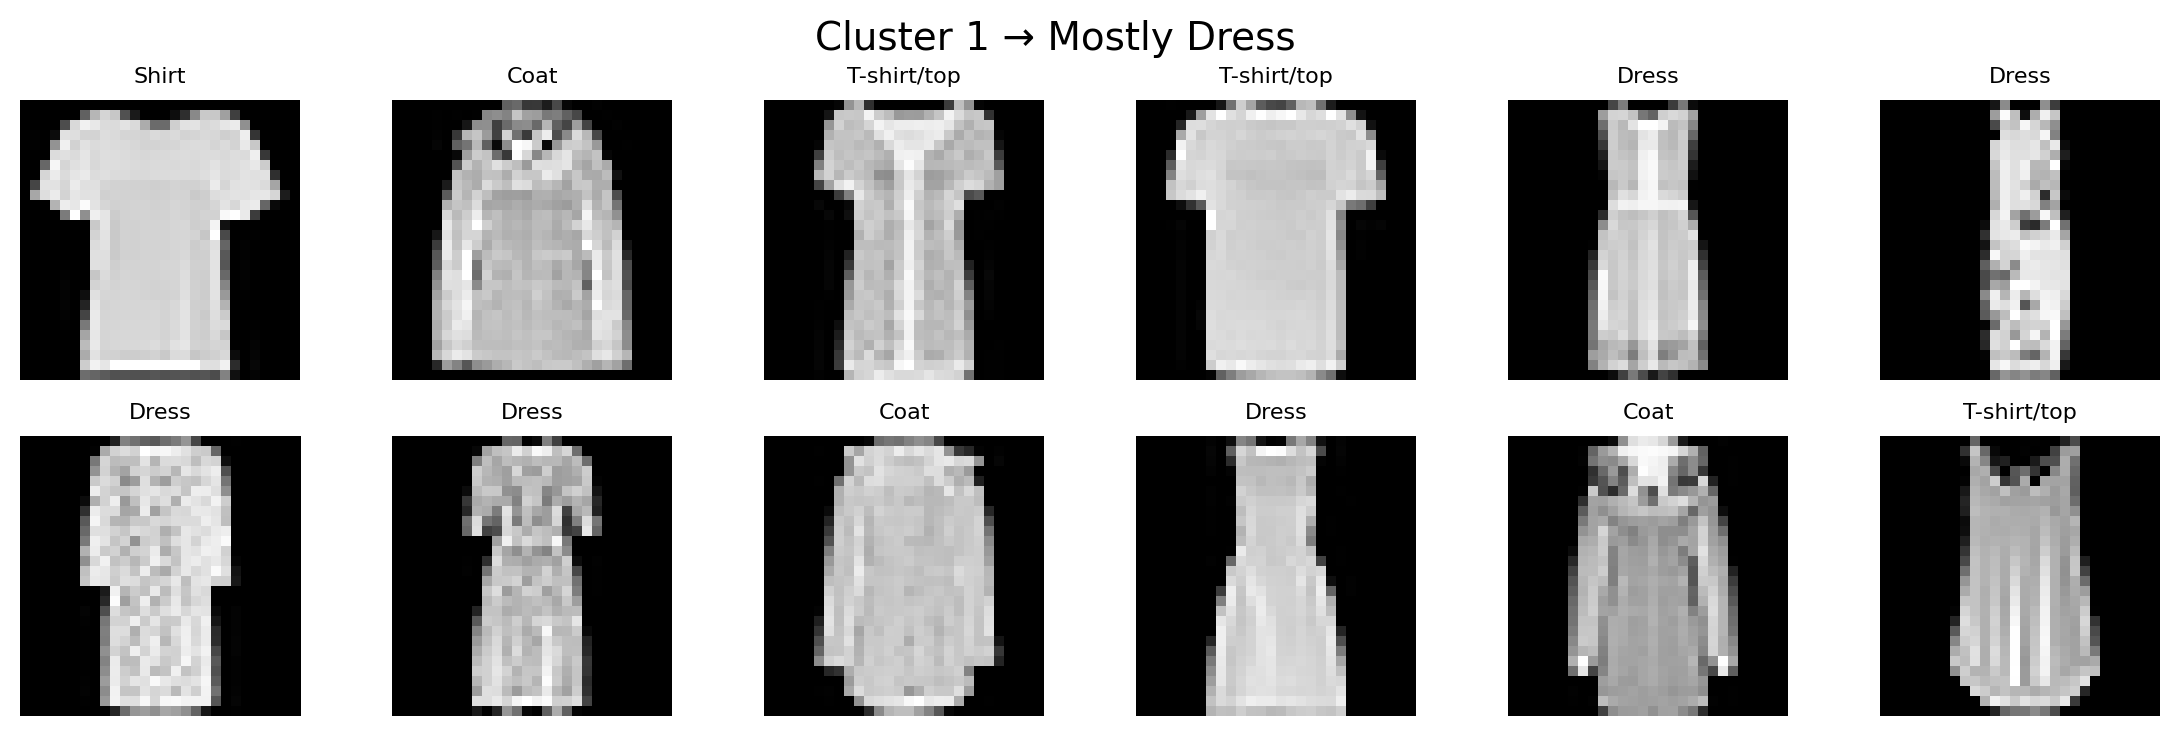

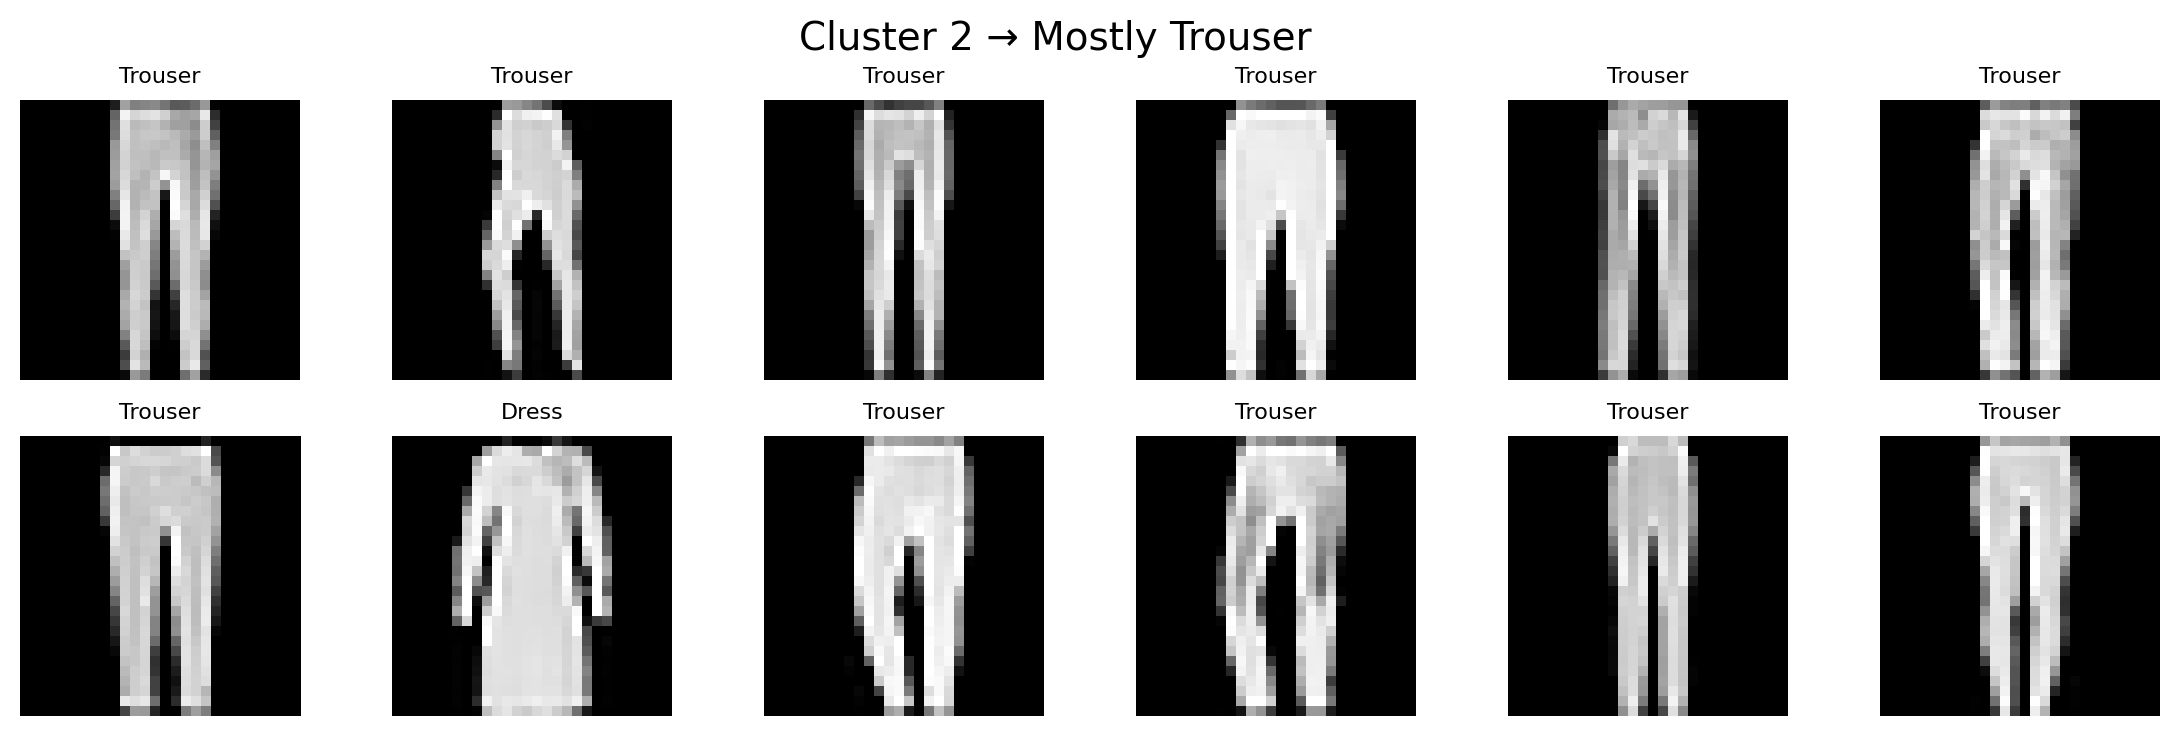

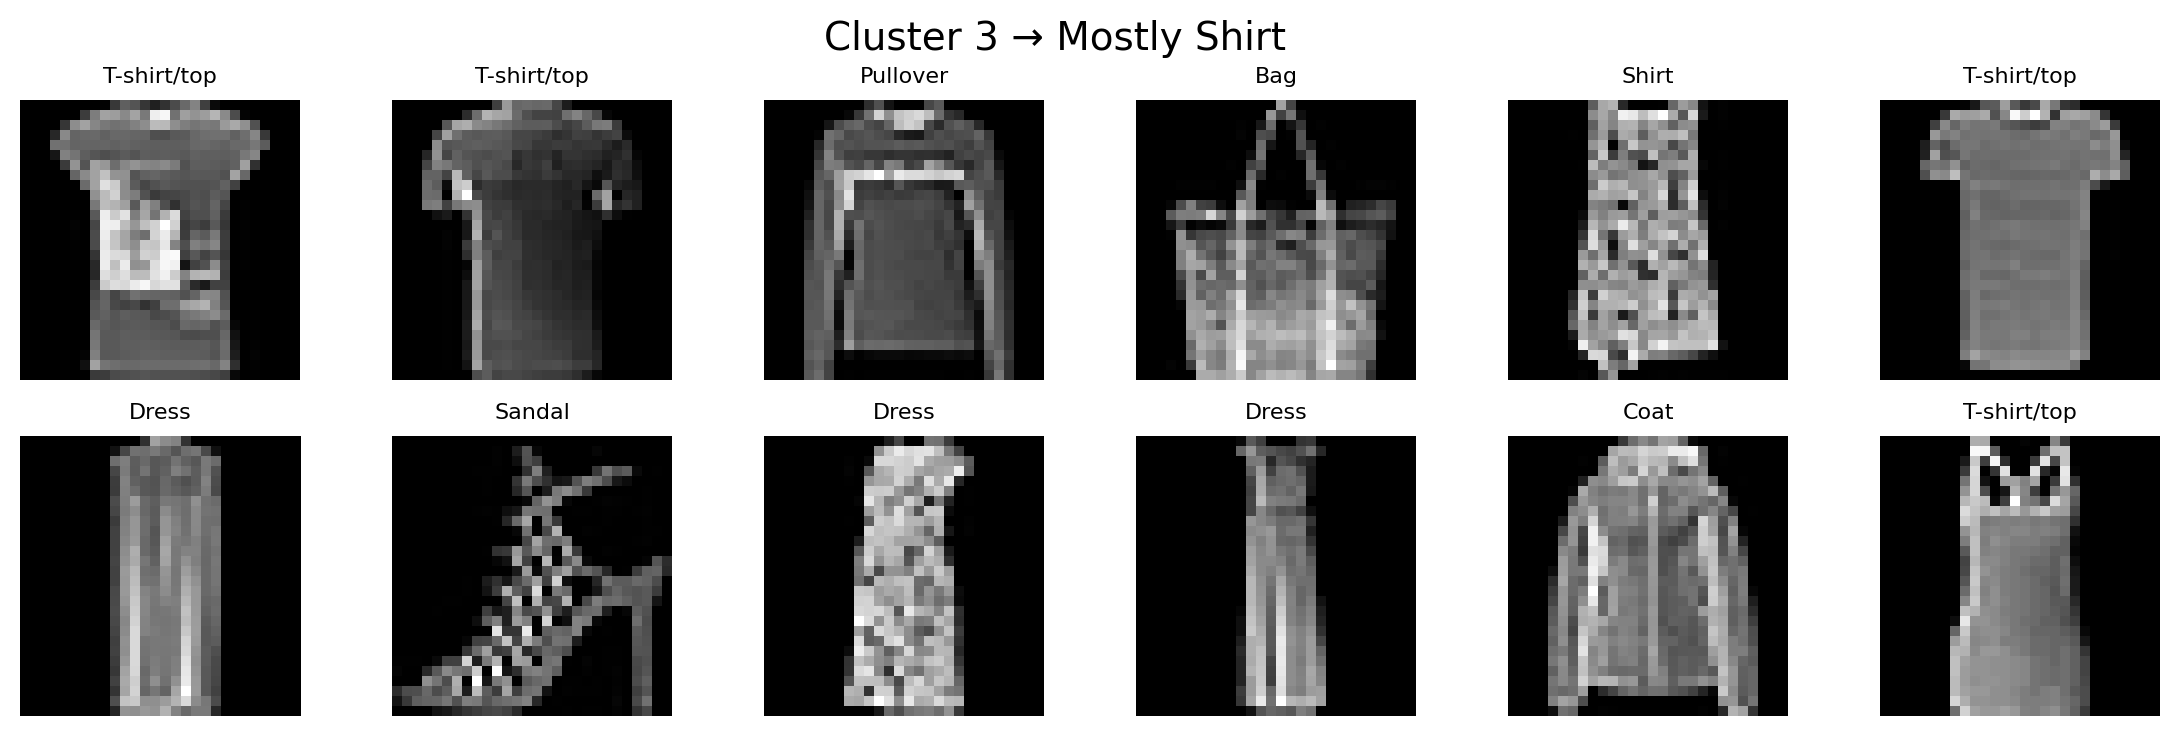

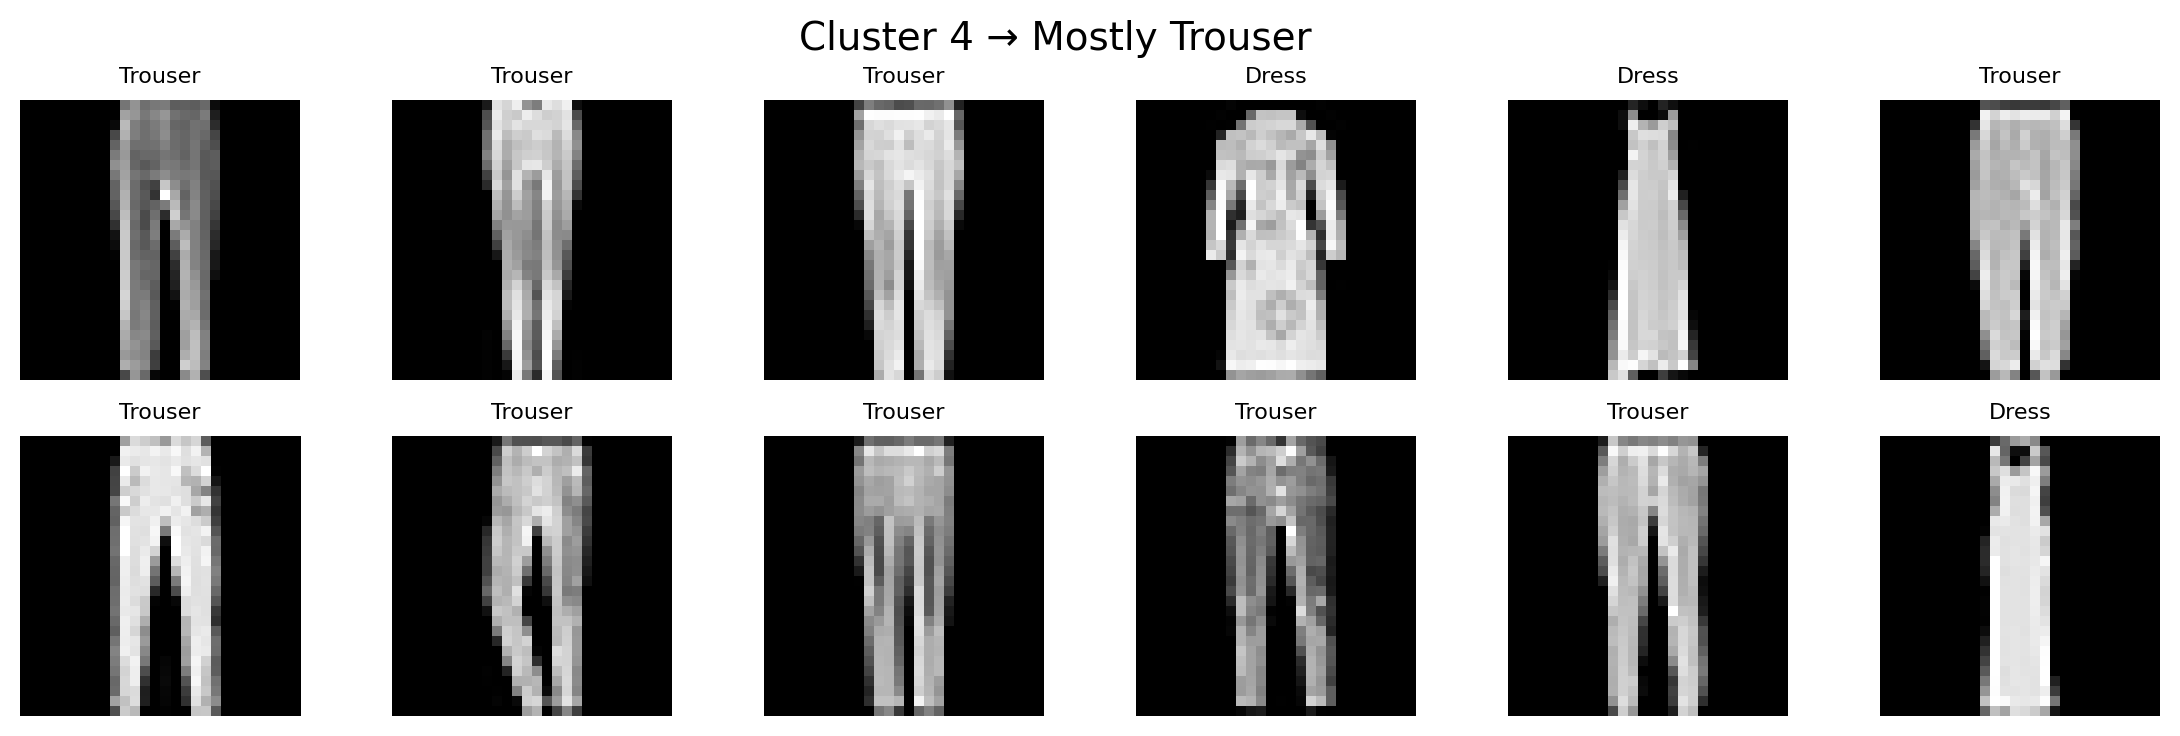

In [10]:
# Cell 8 — Show cluster images
def show_cluster_samples(cluster_id, n=12):
    idx = np.where(clusters == cluster_id)[0]
    if len(idx) == 0:
        print("Cluster", cluster_id, "is empty")
        return
    sel = np.random.choice(idx, size=min(n, len(idx)), replace=False)
    cols = 6
    rows = math.ceil(len(sel)/cols)

    plt.figure(figsize=(14, 2*rows), dpi=200)
    for i, s in enumerate(sel):
        plt.subplot(rows, cols, i+1)
        plt.imshow(x[s], cmap='gray', interpolation='nearest')
        plt.title(label_names[y[s]], fontsize=8)
        plt.axis('off')

    majority_label = np.bincount(y[idx]).argmax()
    plt.suptitle(f"Cluster {cluster_id} → Mostly {label_names[majority_label]}", fontsize=14)
    plt.show()

for c in range(min(K_CLUSTERS, 5)):  # show first 5 clusters
    show_cluster_samples(c, n=12)

**Model Comparison Summary**

Model Performance Comparison

Compares the results of all three models:

Logistic Regression (Accuracy ~71%)

Elastic Net (Accuracy ~75%)

CNN + PCA + KMeans (ARI/NMI clustering scores)
Displays results in a summary table for easy interpretation.


 Final Results:
                          Score/Accuracy  Training Time (s)
Logistic Regression             0.913000          39.204892
Elastic Net                     0.896900          87.076368
XGBoost                         0.967700          63.364145
CNN + PCA + KMeans (ARI)        0.241749                NaN
CNN + PCA + KMeans (NMI)        0.427898                NaN


/tmp/ipython-input-3666930613.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index[:3], y=results_df["Score/Accuracy"][:3], palette="viridis")


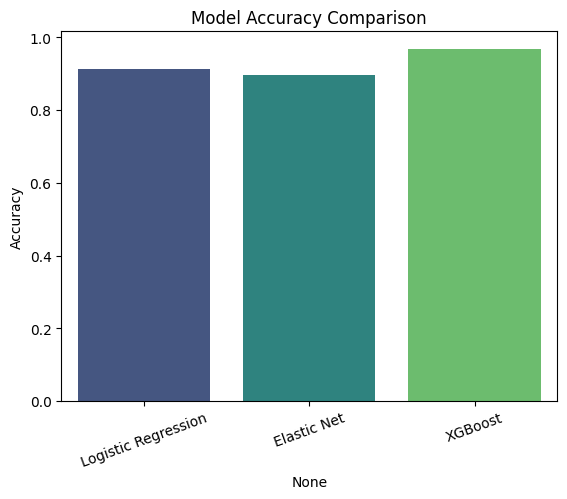

/tmp/ipython-input-3666930613.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index[:3], y=results_df["Training Time (s)"][:3], palette="magma")


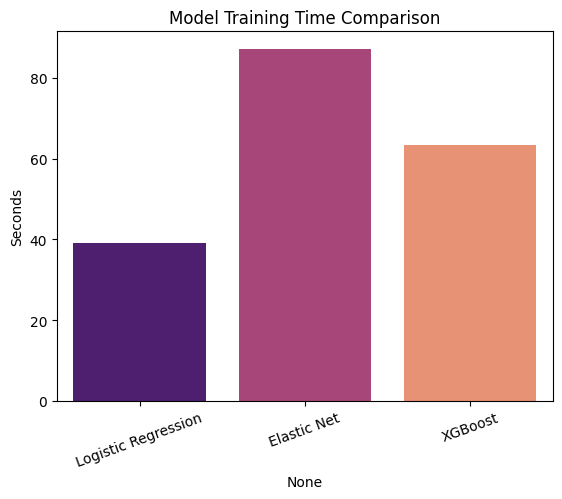

In [11]:
# Cell 9 — Compare Models (Accuracy + Training Time)

results = {
    "Logistic Regression": [acc_log, log_time],
    "Elastic Net": [acc_en, en_time],
    "XGBoost": [acc_xgb, xgb_time],
    "CNN + PCA + KMeans (ARI)": [ari, None],
    "CNN + PCA + KMeans (NMI)": [nmi, None]
}

results_df = pd.DataFrame.from_dict(
    results,
    orient="index",
    columns=["Score/Accuracy", "Training Time (s)"]
)

print("\n Final Results:")
print(results_df)

# Barplot for accuracies
sns.barplot(x=results_df.index[:3], y=results_df["Score/Accuracy"][:3], palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=20)
plt.show()

# Barplot for training times
sns.barplot(x=results_df.index[:3], y=results_df["Training Time (s)"][:3], palette="magma")
plt.title("Model Training Time Comparison")
plt.ylabel("Seconds")
plt.xticks(rotation=20)
plt.show()


#  Conclusion

In this project, we worked on **Fashion-MNIST** dataset to classify and cluster images of clothes using multiple approaches.  
We compared **classical ML models** and **deep learning feature extraction** to evaluate their effectiveness.

-  **Logistic Regression** achieved decent accuracy and proved to be a good baseline.  
-  **Elastic Net Logistic Regression** improved regularization and helped avoid overfitting, but training was slower.  
-  **XGBoost** outperformed Logistic models with better accuracy and faster convergence on structured image features.  
-  **CNN (MobileNetV2) + PCA + KMeans** provided meaningful feature embeddings and allowed us to cluster clothes by type, showing the strength of deep learning for image understanding.  

**Final Observation:**  
- The **best classification model** in terms of accuracy was **XGBoost**.  
- The **best clustering approach** was **CNN + PCA + KMeans**, which grouped similar fashion items together.  
- Overall, combining **deep learning embeddings** with **traditional ML algorithms** gave the most powerful results.
